In [58]:
import logging
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load Data

In [60]:
# experiment specific
result_base_dir = "collinear_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist"

In [61]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
result_dir = os.path.join(result_parent_dir, result_base_dir)
report_dir = os.path.join(result_dir, "report")
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)
output_file = os.path.join(result_dir, "output")  # filename
maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [62]:
# Load data
ms1scans_no_array = pd.read_csv(MS1Scans_NoArray_path)
ms1scans_no_array["scan_number"] = ms1scans_no_array.index.astype(int)
maxquant_result_ref = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_ref.index = maxquant_result_ref["id"]
maxquant_result_exp = pd.read_csv(
    filepath_or_buffer=maxquant_file_exp, sep="\t")
peak_results_matched = pd.read_csv(
    os.path.join(result_dir, "peak_results_matched.csv"))
peak_results = pd.read_csv(os.path.join(result_dir, "peak_results.csv"))
peak_selection_result_dir = os.path.join(
    report_dir, "peak_selection_5d_input_remove_large_RT_diff_true_peaks"
)
# Load model
cnn_model = tf.keras.models.load_model(
    os.path.join(peak_selection_result_dir, "peak_cnn_log_int_cos_dist.keras")
)

In [63]:
# Load activation
activation = np.load(output_file + "_activationByScanFromLasso.npy")
activation_df = pd.DataFrame(activation, index=maxquant_result_ref.id)

# Load PS cosine distance
cos_dist = np.load(output_file + "_precursor_scan_CosDist.npy")
cos_dist_df = pd.DataFrame(cos_dist, index=maxquant_result_ref.id)

# Load colllinearity result
n_collinear_precursor = np.load(output_file + "_n_collinear_precursor.npy")
n_collinear_precursor_df = pd.DataFrame(
    n_collinear_precursor, index=maxquant_result_ref.id
)

# Apply peak selection models
peak_results mark the annotated data:
- matched: binary classification task


In [64]:
collinear_precursors = np.load(
    output_file + "_collinearPrecursors.npy", allow_pickle=True
)

In [65]:
collinear_precursors_df = pd.DataFrame(
    collinear_precursors, index=maxquant_result_ref.id
)

In [66]:
peak_results_search_range_pred_score = pd.read_csv(
    peak_selection_result_dir + "/peak_results_search_range_pred_score.csv"
)
peak_results_search_range_pred_score_filtered = peak_results_search_range_pred_score[
    peak_results_search_range_pred_score["pred_score"] > 0.4
]

In [67]:
import matplotlib.pyplot as plt

candidate_peaks = {}
precursor_id = 4
precursor_peaks = peak_results_search_range_pred_score_filtered[
    peak_results_search_range_pred_score_filtered["id"] == precursor_id
]
for i, row in precursor_peaks.iterrows():
    plt.plot(activation_df.loc[precursor_id,
             row["start_scan"]: row["end_scan"] + 1])
    plt.show()
    collinear_precursors_df.loc[precursor_id,
                                row["start_scan"]: row["end_scan"] + 1]
    print(peak_results_search_range_pred_score_filtered.loc[i, "pred_score"])

In [68]:
a = n_collinear_precursor_df.sum(axis=1)

In [69]:
non_collinear_rows = a[a < 2].index

## Generate sequence and labels

In [7]:
peak_results_search_range = pd.merge(
    left=peak_results.reset_index(),
    right=maxquant_result_ref[["RT_search_left", "RT_search_right"]],
    right_index=True,
    left_on="id",
    how="left",
)

In [9]:
# filter by int AUC
peak_results_search_range["peak_intensity_auc_log"] = np.log10(
    peak_results_search_range["peak_intensity_auc"]
)
peak_results_search_range = peak_results_search_range[
    peak_results_search_range["peak_intensity_auc_log"] > 3.5
]

In [10]:
%autoreload 2
from postprocessing.peak_selection import prepare_seq_and_label
import matplotlib.pyplot as plt

cos_dist_seq, cos_dist_label = prepare_seq_and_label(
    peak_results=peak_results_search_range,
    activation_df=cos_dist_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    max_len=361,
    log_intensity=False,
)

2024-03-04 10:02:12,284 - postprocessing.peak_selection - INFO - Match time to scan for the peak results dataframe.
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/tools.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_scan_col] = ms1scans_no_array.iloc[indices]["scan_number"].values
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/tools.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_scan_col] = ms1scans_no_array.iloc[indices]["scan_number"].values
2024-03-04 10:02:41,53

In [ ]:
scan_index = np.tile(activation_df.columns.values, (activation_df.shape[0], 1))
scan_index_df = pd.DataFrame(
    scan_index, index=activation_df.index, columns=activation_df.columns
)
scan_index_df = scan_index_df.astype(float)

In [ ]:
scan_index_seq, scan_index_label = prepare_seq_and_label(
    peak_results=peak_results_search_range,
    activation_df=scan_index_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    max_len=361,
    log_intensity=False,
)

2024-02-26 15:46:53,693 - postprocessing.peak_selection - INFO - Padded sequence shape: (251462, 361)
2024-02-26 15:46:53,695 - postprocessing.peak_selection - INFO - Sequence shape: (251462, 361)
2024-02-26 15:46:53,696 - postprocessing.peak_selection - INFO - Label shape: (251462,)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/peak_selection.py:286: RuntimeWarning: invalid value encountered in cast
  return seq, label.astype(np.int32)


In [ ]:
from utils.tools import match_time_to_scan

maxquant_result_ref = match_time_to_scan(
    df=maxquant_result_ref,
    ms1scans_no_array=ms1scans_no_array,
    time_cols=["RT_search_center"],
)
rt_search_center_scan_df = pd.DataFrame(
    index=activation_df.index, columns=activation_df.columns
)
rt_search_center_scan_df = rt_search_center_scan_df.apply(
    lambda _: maxquant_result_ref["RT_search_center_scan"]
)
rt_search_center_scan_df = rt_search_center_scan_df.astype(float)

In [ ]:
rt_search_center_scan_seq, rt_search_center_scan_label = prepare_seq_and_label(
    peak_results=peak_results_search_range,
    activation_df=rt_search_center_scan_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    max_len=361,
    log_intensity=False,
)

2024-02-26 15:47:22,833 - postprocessing.peak_selection - INFO - Padded sequence shape: (251462, 361)
2024-02-26 15:47:22,834 - postprocessing.peak_selection - INFO - Sequence shape: (251462, 361)
2024-02-26 15:47:22,834 - postprocessing.peak_selection - INFO - Label shape: (251462,)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/peak_selection.py:286: RuntimeWarning: invalid value encountered in cast
  return seq, label.astype(np.int32)


In [11]:
peak_seq, peak_label = prepare_seq_and_label(
    peak_results=peak_results_search_range,
    activation_df=activation_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize="minmax",
    pad=True,
    max_len=361,
    log_intensity=True,
)

2024-03-04 10:04:14,212 - postprocessing.peak_selection - INFO - Padded sequence shape: (251462, 361)
2024-03-04 10:04:14,213 - postprocessing.peak_selection - INFO - Sequence shape: (251462, 361)
2024-03-04 10:04:14,214 - postprocessing.peak_selection - INFO - Label shape: (251462,)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/peak_selection.py:286: RuntimeWarning: invalid value encountered in cast
  return seq, label.astype(np.int32)


peak_seq_4d_input = np.dstack(
    (peak_seq, cos_dist_seq, scan_index_seq, rt_search_center_scan_seq)
)

peak_seq_2d_input = np.dstack((peak_seq, cos_dist_seq))

In [12]:
n_collinear_precursor_df = n_collinear_precursor_df.astype(float)
collinear_seq, _ = prepare_seq_and_label(
    peak_results=peak_results_search_range,
    activation_df=n_collinear_precursor_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    max_len=361,
    log_intensity=False,
)

2024-03-04 10:05:00,226 - postprocessing.peak_selection - INFO - Padded sequence shape: (251462, 361)
2024-03-04 10:05:00,228 - postprocessing.peak_selection - INFO - Sequence shape: (251462, 361)
2024-03-04 10:05:00,228 - postprocessing.peak_selection - INFO - Label shape: (251462,)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/peak_selection.py:286: RuntimeWarning: invalid value encountered in cast
  return seq, label.astype(np.int32)


In [15]:
peak_seq_3d_input = np.dstack((peak_seq, cos_dist_seq, collinear_seq))

In [15]:
peak_seq_5d_input = np.dstack(
    (peak_seq, cos_dist_seq, collinear_seq,
     scan_index_seq, rt_search_center_scan_seq)
)

peak_seq_3d_input = np.dstack((peak_seq, cos_dist_seq, collinear_seq))

## Peak sequence classification

In [17]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((peak_seq_3d_input)).batch(1024)

In [18]:
from postprocessing.peak_selection import (
    produce_pred_df,
    get_top_n_scored_peaks_by_precursor,
)

pred_df = produce_pred_df(
    model=cnn_model,
    data=dataset,
    precursor_id=peak_results_search_range.id,
    data_idx=peak_results_search_range.index,
)

2024-03-04 10:05:40.824338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [251462,361,3]
	 [[{{node Placeholder/_0}}]]


246/246 [==============================] - 26s 91ms/step


In [19]:
peak_results_search_range_pred_score = peak_results_search_range.copy()
peak_results_search_range_pred_score["pred_score"] = pred_df["y_pred_prob"]

In [21]:
pred_df.to_csv(os.path.join(peak_selection_result_dir, "pred_df.csv"))
peak_results_search_range_pred_score.to_csv(
    os.path.join(peak_selection_result_dir, "peak_results_search_range_pred_score.csv")
)

# Analyze peak scoring result

In [70]:
peak_results_search_range_pred_score = pd.read_csv(
    os.path.join(peak_selection_result_dir, "peak_results_search_range_pred_score.csv")
)
pred_df = pd.read_csv(os.path.join(peak_selection_result_dir, "pred_df.csv"))
# sum_peak = pd.read_csv(os.path.join(peak_selection_result_dir, "sum_peak_cls.csv"))

2024-03-07 14:26:37,168 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64


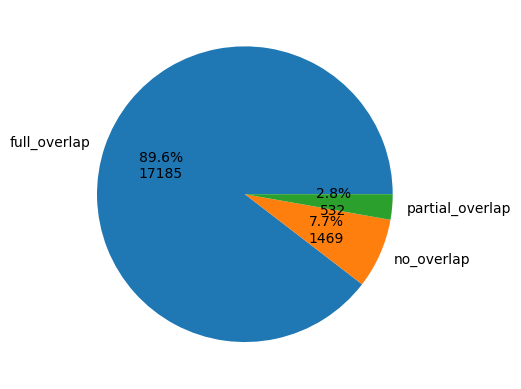

2024-03-07 14:26:37,271 - result_analysis.result_analysis - INFO - No filter_by_rt_overlap is specified, use all entries for plotting.
2024-03-07 14:26:37,278 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 19186 -> 18753
2024-03-07 14:26:37,378 - postprocessing.peak_selection - INFO - Use RT range as reference for peak selection.


In [71]:
# match peaks to experiment
from result_analysis import result_analysis
from postprocessing.peak_selection import match_peaks_to_exp

if peak_results_search_range_pred_score.matched.isna().sum() > 0:
    sbs_result = result_analysis.SBSResult(
        maxquant_ref_df=maxquant_result_ref,
        maxquant_exp_df=maxquant_result_exp,
        sum_peak=sum_peak,
    )

    sbs_result.compare_with_maxquant_exp_int(
        filter_by_rt_overlap=None, handle_mul_exp_pcm="drop", save_dir=None
    )
    merged_df = sbs_result.ref_exp_df_inner
    peak_results_search_range_pred_score_matched = match_peaks_to_exp(
        ref_exp_inner_df=merged_df, peak_results=peak_results_search_range_pred_score
    )
    peak_results_search_range_pred_score_matched.to_csv(
        os.path.join(
            peak_selection_result_dir,
            "peak_results_search_range_pred_score_matched.csv",
        )
    )

<Axes: >

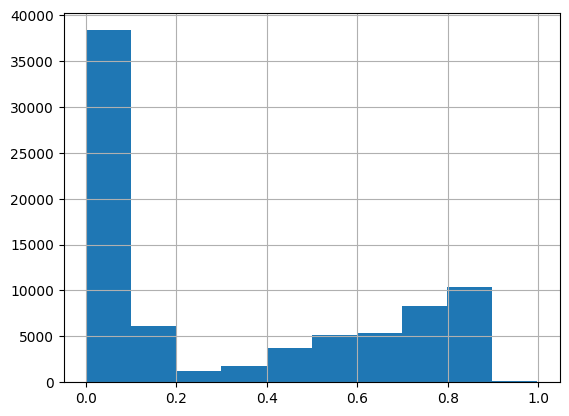

In [72]:
peak_results_search_range_pred_score_matched.pred_score.hist()

In [74]:
peak_results_search_range_filtered = peak_results_search_range_pred_score[
    peak_results_search_range_pred_score["pred_score"] >= 0.3
]

# Compare quant (only matched)

In [75]:
from postprocessing.peak_selection import get_top_n_scored_peaks_by_precursor

top_1_peak = get_top_n_scored_peaks_by_precursor(
    peak_results_search_range_pred_score,
    top_n=1,
    id_col="id",
    score_col="pred_score",
)

In [32]:
top_1_peak.matched.value_counts(normalize=True)
top_1_peak.loc[top_1_peak["matched"], "pred_score"].hist()

Series([], dtype: float64)

<Axes: >

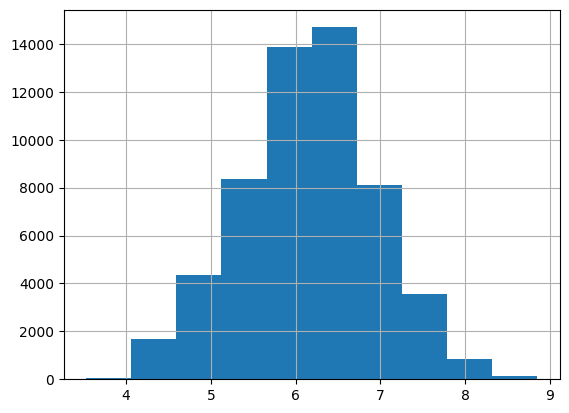

In [77]:
from postprocessing.peak_selection import filter_and_aggregate_intensity

sum_peak_cls = filter_and_aggregate_intensity(
    top_1_peak, threshold=0.0, by_matched=False
)
np.log10(sum_peak_cls.peak_intensity_auc + 1).hist()

# Result Evaluation

In [78]:
sum_peak_cls_aligned = (
    pd.merge(
        left=maxquant_result_ref[["id"]],
        right=sum_peak_cls,
        left_index=True,
        right_on="id",
        how="left",
    )
    .drop(["id", "id_x", "id_y"], axis=1)
    .rename(columns={"peak_intensity_auc": "AUCActivationPeakCls"})
)
sum_peak_cls_aligned.to_csv(os.path.join(
    peak_selection_result_dir, "sum_peak_cls.csv"))

In [79]:
sum_peak_cls_non_collinear = sum_peak_cls_aligned.copy()
sum_peak_cls_non_collinear.index = maxquant_result_ref.id
sum_peak_cls_non_collinear[
    ~sum_peak_cls_non_collinear.index.isin(non_collinear_rows)
] = 0

In [80]:
from result_analysis.result_analysis import SBSResult

sum_peak_cls_aligned = pd.read_csv(
    os.path.join(peak_selection_result_dir, "sum_peak_cls.csv")
)
sbs_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_exp_df=maxquant_result_exp,
    sum_peak=sum_peak_cls_aligned,
    # sum_raw=sum_peak,
)

2024-03-07 14:28:15,500 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64


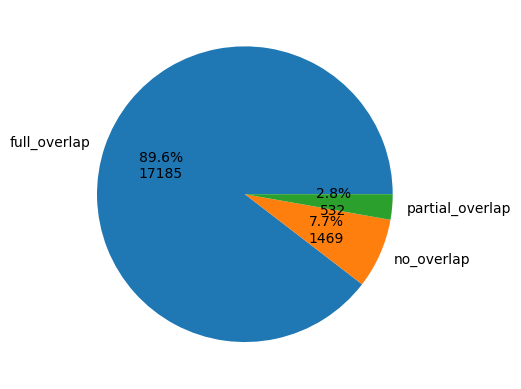

2024-03-07 14:28:15,633 - result_analysis.compare_maxquant - INFO - Removing 2001 entries with RT_overlap ['full_overlap'], 17185 entries left.
2024-03-07 14:28:15,639 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 17185 -> 17009


In [81]:
from result_analysis.result_analysis import SBSResult

sbs_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_exp_df=maxquant_result_exp,
    sum_peak=sum_peak_cls_non_collinear,
    # sum_raw=sum_peak,
)
sbs_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=["full_overlap"],
    handle_mul_exp_pcm="drop",
    save_dir=None,
)

In [82]:
sbs_result.plot_intensity_corr(
    inf_col="AUCActivationPeakCls",
    save_dir=None,
    interactive=True,
    contour=False,
    hover_data=["id"],
)

Data:  Intensity_log AUCActivationPeakCls_log , slope =  0.89 , intercept =  -0.784 , PearsonR =  0.853 , SpearmanR =  0.843


In [36]:
sbs_result.plot_overlap_with_MQ(
    show_ref=True, save_dir=peak_selection_result_dir)

/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ref_df_non_zero["precursor"] = self.ref_df_non_zero[


In [83]:
ref_exp_outer = sbs_result.ref_exp_df_inner

# Activations

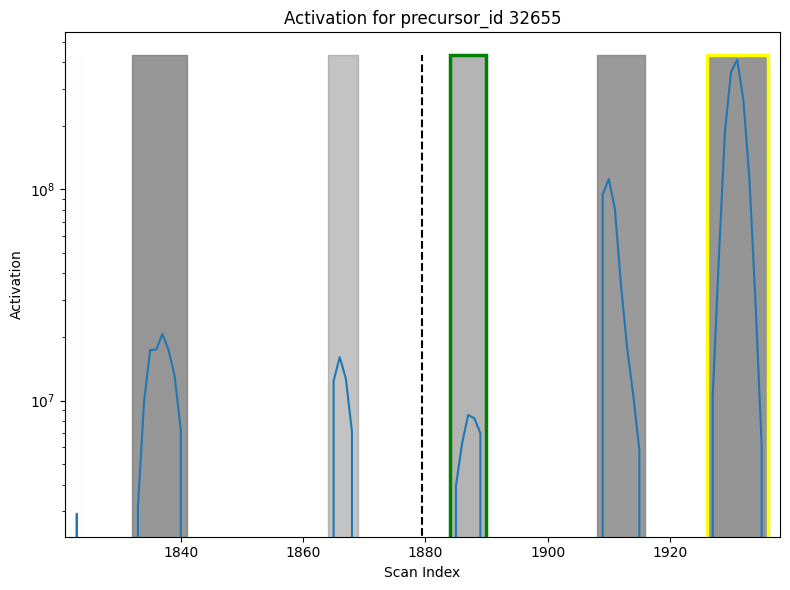

In [84]:
from postprocessing.peak_selection import plot_activation_and_score

plot_activation_and_score(
    peak_results=peak_results_search_range_pred_score_matched,
    df_test=pred_df,
    activation=activation_df,
    precursor_id=32655,
)

In [57]:
tmp_df = activation_df.loc[:, 1643:1650]
non_zero_rows = tmp_df.sum(axis=1) > 0
a = tmp_df.loc[non_zero_rows]

In [86]:
collinear_precursors_df.loc[32655, 1820:1940].isna().sum()

121

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



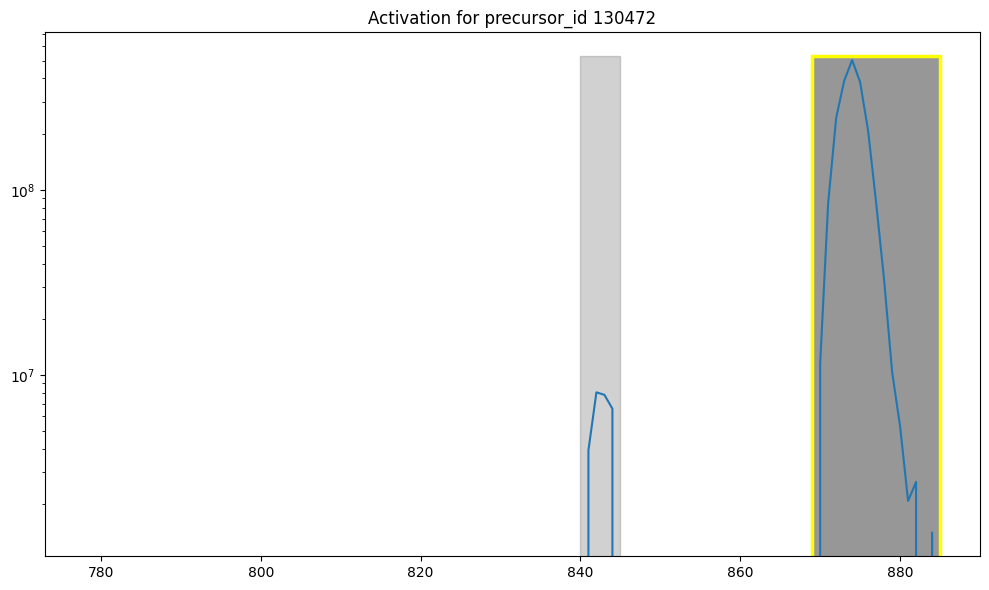

In [32]:
plot_activation_and_score(
    peak_results=peak_results_search_range_pred_score,
    df_test=pred_df,
    activation=activation_df,
    precursor_id=130472,
)

In [39]:
peak_results_search_range_pred_score_matched.columns

Index(['Unnamed: 0', 'index', 'id', 'apex_scan', 'apex_time', 'start_scan',
       'start_time', 'end_scan', 'end_time', 'peak_width', 'peak_height',
       'peak_intensity_auc', 'rt_search_center_diff',
       'closest_to_search_center', 'matched', 'RT_search_left',
       'RT_search_right', 'peak_intensity_auc_log', 'RT_search_left_scan',
       'RT_search_right_scan', 'pred_score', 'Calibrated retention time start',
       'Calibrated retention time', 'Calibrated retention time finish',
       'RT_apex_diff', 'RT_start_diff', 'RT_end_diff', 'RT_diff_sum'],
      dtype='object')

In [42]:
peak_results_search_range_pred_score.drop(
    ["matched", "matched_matched"], axis=1, inplace=True
)
peak_results_search_range_pred_score = pd.merge(
    left=peak_results_search_range_pred_score,
    right=peak_results_search_range_pred_score_matched[
        ["id", "matched", "apex_scan", "start_scan"]
    ],
    on=["id", "start_scan", "apex_scan"],
    how="left",
    suffixes=("", "_matched"),
)

In [46]:
peak_results_search_range_pred_score.matched.fillna(False, inplace=True)

ValueError: Axis limits cannot be NaN or Inf

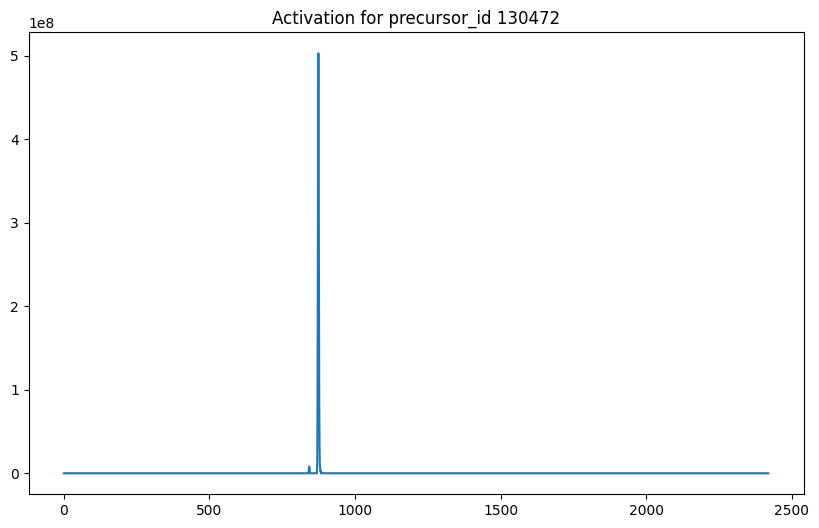

In [48]:
plot_activation_and_score(
    peak_results=peak_results_search_range_pred_score_matched,
    df_test=pred_df,
    activation=activation_df,
    precursor_id=130472,
)

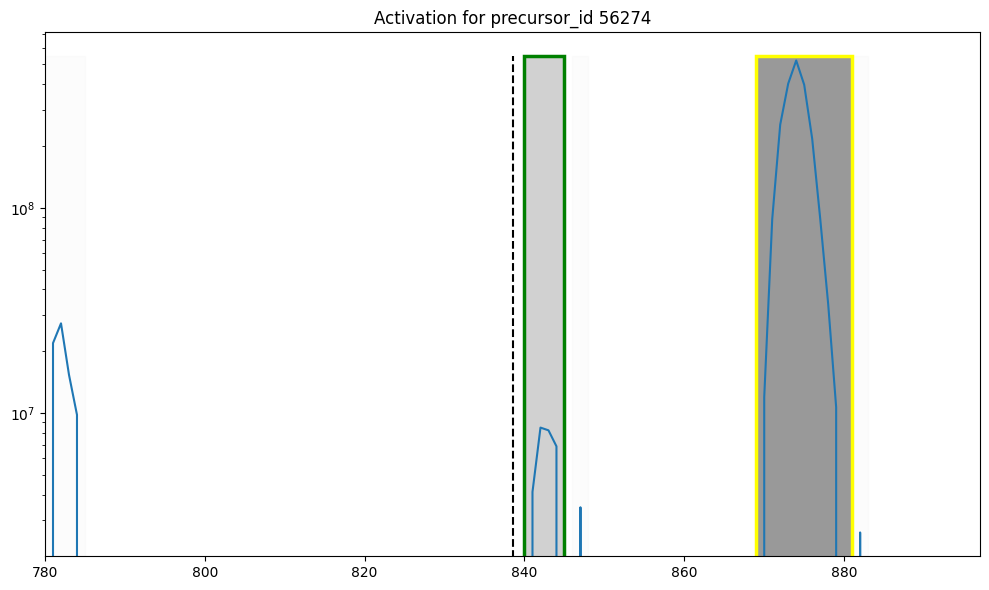

In [37]:
plot_activation_and_score(
    peak_results=peak_results_search_range_pred_score_matched,
    df_test=pred_df,
    activation=activation_df,
    precursor_id=56274,
)

In [ ]:
collinear_precursor = np.load(
    output_file + "_collinearPrecursors.npy", allow_pickle=True
)
collinear_precursor_df = pd.DataFrame(collinear_precursor, index=maxquant_result_ref.id)

In [26]:
collinear_precursor_df.loc[56274, 840:880]

840                         NaN
841                    [130472]
842                    [130472]
843                    [130472]
844            [116937, 130472]
845                         NaN
846                         NaN
847                         NaN
848                         NaN
849                         NaN
850                         NaN
851                         NaN
852                         NaN
853                         NaN
854                         NaN
855                         NaN
856                         NaN
857                         NaN
858                         NaN
859                         NaN
860                         NaN
861                         NaN
862                         NaN
863                         NaN
864                         NaN
865                         NaN
866                         NaN
867                         NaN
868                         NaN
869                         NaN
870            [116937, 130472]
871    [